In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
eastmoney = pd.read_csv('/content/drive/MyDrive/eastmoney_data_senti.csv')

<ipython-input-4-aea18ec24f7a>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  eastmoney = pd.read_csv('/content/drive/MyDrive/eastmoney_data_senti.csv')


# Preprocessing

In [ ]:
eastmoney.fillna('0', inplace=True)

# 对article_source进行分类
# 将含有东方财富的归为一类
# 将含有choice的归位一类

def categorize_source(source):
    source = str(source)
    if '东方财富' in source:
        return '东方财富'
    elif 'Choice数据' in source:
        return 'Choice数据'
    else:
        return source

# 变为category类
eastmoney['article_source_cate'] = eastmoney['article_source_cate'].astype('category')
unique_values = eastmoney['article_source_cate'].unique()
print(unique_values)

In [ ]:
!pip install snownlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=625a578124dfb7a07a419690ed3f1e52b1b4129b87519b0a442a37d17f6de6dc
  Stored in directory: /root/.cache/pip/wheels/43/f3/70/8990fc249efeb396007766676706f71dd3d1ca3c023ce522ce
Successfully built snownlp


#Sentiment analysis

In [ ]:
sentiment_dict = {}
with open('media_sentiment_score.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            word, score = parts
            sentiment_dict[word] = float(score)

In [ ]:
import pandas as pd
import jieba
from snownlp import SnowNLP
from collections import Counter

def analyze_sentiment(title, sentiment_dict):
    words = jieba.lcut(title)
    # 计算情感得分
    score = 0
    for word in words:
        if word in sentiment_dict:
            # 使用自定义词典的得分
            score += sentiment_dict[word]
        else:
            # 使用SnowNLP的情感得分并转换范围到-1到1
            snownlp_score = SnowNLP(word).sentiments
            adjusted_score = snownlp_score * 2 - 1
            score += adjusted_score
    # 标准化得分
    normalized_score = score / len(words)
    return normalized_score

In [ ]:
#词频统计
item_titles = eastmoney['item_title'].dropna().tolist()
words = []
for title in item_titles:
    # 使用jieba进行分词并过滤非字母字符
    words.extend([word for word in jieba.lcut(title) if word.isalpha()])

# 进行词频统计
word_freq = Counter(words)
print(word_freq.most_common(50))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 5.007 seconds.
DEBUG:jieba:Loading model cost 5.007 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


KeyboardInterrupt: 

In [ ]:
# 计算每个标题的情感得分并创建新列
eastmoney['sentiment_score'] = eastmoney['item_title'].apply(analyze_sentiment, sentiment_dict= sentiment_dict)

# 查看带有情感得分的DataFrame6
print(eastmoney['sentiment_score'])

In [ ]:
# 统计每个情感得分的频率
sentiment_counts = eastmoney['sentiment_score'].value_counts()

# 打印得分的统计情况
print(sentiment_counts)

# Sentiment analysis(drop stopwords to caculate the score)




In [ ]:
def load_stopwords(filepath):
    stopwords = set()  # 使用set来存储停用词，避免重复且提高查找效率
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            stopwords.add(line.strip())
    return stopwords

stopwords = load_stopwords('/content/hit_stopwords.txt')

In [ ]:
sentiment_dict = {}
with open('media_sentiment_score.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 2:
            word, score = parts
            sentiment_dict[word] = float(score)

In [ ]:
import jieba
import re

# 去除文本中的标点符号
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 去除停用词
def remove_stopwords(text, stopwords):
    words = jieba.cut(text)
    words_filtered = [word for word in words if word not in stopwords]
    return ' '.join(words_filtered)  # 返回分词后的字符串，词之间以空格分隔

# 预处理文本，包括去除标点和停用词
def preprocess_text(text, stopwords):
    text = remove_punctuation(text)
    text = remove_stopwords(text, stopwords)
    return text

In [ ]:
pip install snownlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 39.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=dec6703cee9f16e7b789f327d4808436c308d7515635794e8113e97c5f3a9d3c
  Stored in directory: /root/.cache/pip/wheels/43/f3/70/8990fc249efeb396007766676706f71dd3d1ca3c023ce522ce
Successfully built snownlp


In [ ]:
import pandas as pd
import jieba
from snownlp import SnowNLP
from collections import Counter

def analyze_sentiment(title, stopwords, sentiment_dict):
    title = preprocess_text(title, stopwords)  # 预处理标题
    words = jieba.lcut(title)  # 再次分词
    score = 0
    for word in words:
        if word in sentiment_dict:
            score += sentiment_dict[word]
        else:
            snownlp_score = SnowNLP(word).sentiments
            adjusted_score = snownlp_score * 2 - 1
            score += adjusted_score
    normalized_score = score / len(words) if words else 0  # 防止除以零错误
    return normalized_score

In [ ]:
# 计算每个标题的情感得分并创建新列
eastmoney['drop_sentiment_score'] = eastmoney['item_title'].apply(lambda x: analyze_sentiment(x, stopwords, sentiment_dict))

Compare the score of original sentiment score with score dropping the stopwords. The result of original one looks good. So use the sentiment score in the following steps.

In [ ]:
#随机查看样本
import pandas as pd

sampled_data = eastmoney.sample(20, random_state=1)  # 使用random_state确保结果可复现
print(sampled_data[['item_title', 'sentiment_score','drop_sentiment_score']])

                              item_title  sentiment_score  \
6082451        九安医疗董事长回应兜底增持：对公司未来长期发展坚定         0.432288   
4962086              新洁能07月14日被沪股通减持33万股        -0.176380   
712516          英科医疗11月10日被深股通减持171.29万股        -0.210590   
5884660            中富通2018年度净利润预增25%-50%        -0.037155   
1293733   招商证券：主力资金连续6天净流出累计2.46亿元（12-16         0.006954   
5249615   哈铁科技：融资净偿还79.7万元，融资余额4233.93万元         0.156243   
2431342   齐心集团：融资净买入143.75万元，融资余额1.83亿元（         0.246737   
2621497        青农商行(002958)融资融券信息(03-02)         0.039410   
4137228      【图解季报】抚顺特钢：2021年一季度归母净利润同比大         0.118083   
6426472                  长安信托产品逾期 恒银科技踩雷         0.284918   
4520774  广深铁路：连续7日融资净买入累计2127.57万元（01-11         0.164345   
6195490        瑞茂通：公司开展的生物柴油业务主要销往荷兰等欧洲国         0.078935   
3626251         章源钨业（002378）龙虎榜数据（04-08）         0.103458   
270392         国信证券首次给予报喜鸟买入评级 目标价5.6~6元         0.123501   
253464      东港股份本周融资净买入805.29万元，居造纸印刷板块第         0.164250   
217472      达安基因本周融资净偿还3

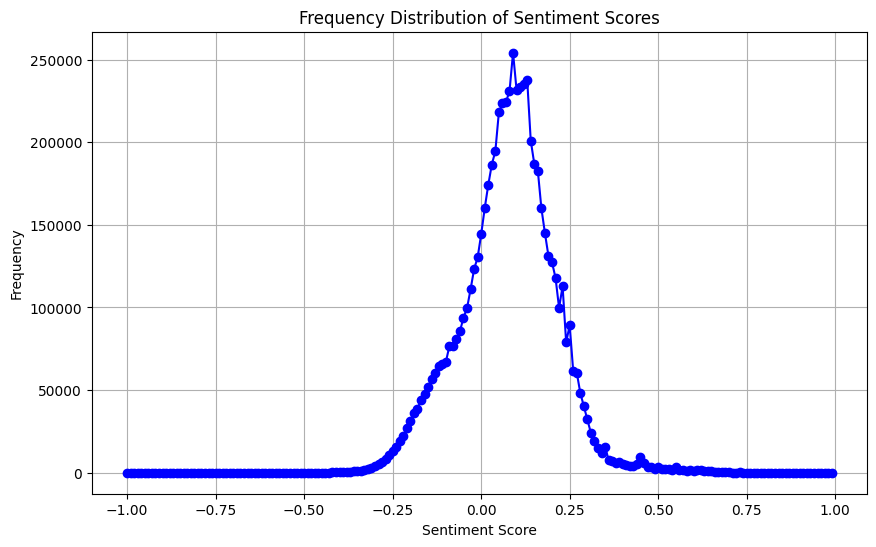

In [ ]:
#绘制得分结果
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 计算频数
score_range = np.arange(-1, 1.01, 0.01)  # 从-1到1，步长为0.01
freq, bins = np.histogram(eastmoney['sentiment_score'], bins=score_range)

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], freq, marker='o', linestyle='-', color='b')  # 使用bins的左端点作为x值
plt.title('Frequency Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Punctuation marks of eastmoney[item_title]

In [ ]:
def update_punctuation_marks(eastmoney):
    item_title_value = str(eastmoney['item_title'])

    #"！"
    eastmoney['exclamation_mark'] = 1 if '！' in item_title_value else 0

    # "？"
    eastmoney['question_mark'] = 1 if '？' in item_title_value else 0

    # "："
    eastmoney['colon_mark'] = 1 if '：' in item_title_value else 0

update_punctuation_marks(eastmoney)

def caculate_punctuation_marks(df):
    eastmoney['exclamation_mark'] = eastmoney['item_title'].apply(lambda x: 1 if '！' in x else 0)
    eastmoney['question_mark'] = eastmoney['item_title'].apply(lambda x: 1 if '？' in x else 0)
    eastmoney['colon_mark'] = eastmoney['item_title'].apply(lambda x: 1 if '：' in x else 0)

caculate_punctuation_marks(eastmoney)
exclamation_count = eastmoney['exclamation_mark'].sum()
question_count = eastmoney['question_mark'].sum()
colon_count = eastmoney['colon_mark'].sum()

path = '/content/drive/MyDrive/eastmoney_special_symbols.csv'
eastmoney.to_csv(path, index=False)


In [ ]:
print("包含 '！' 的条目数量:", exclamation_count)
print("包含 '？' 的条目数量:", question_count)
print("包含 '：' 的条目数量:", colon_count)

包含 '！' 的条目数量: 62821
包含 '？' 的条目数量: 20609
包含 '：' 的条目数量: 3115157


# LDA

In [ ]:
import pandas as pd
eastmoney = pd.read_csv('/content/drive/MyDrive/eastmoney_special_symbols.csv')

In [ ]:
print(eastmoney.columns)

Index(['item_title', 'item_author', 'article_author', 'article_source',
       'item_views', 'item_comment_counts', 'article_likes', 'year', 'month',
       'eastmoney_robo_journalism', 'media_robo_journalism',
       'SMA_robo_journalism', 'viral', 'article_source_cate',
       'item_author_cate', 'sentiment_score', 'drop_sentiment_score',
       'exclamation_mark', 'question_mark', 'colon_mark'],
      dtype='object')


Lda model with num_topics=5

In [ ]:
import pandas as pd
import jieba
from gensim import corpora, models
import re

# 去除文本中的标点符号
def remove_punctuation(text):
    # 使用正则表达式去除标点
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# 加载停用词列表
stop_words = set()
with open('hit_stopwords.txt', 'r', encoding='utf-8') as file:  # 假设停用词列表文件名为 chinese_stop_words.txt
    for word in file:
        stop_words.add(word.strip())
def remove_stopwords(words):
    words = [word for word in words if word not in stop_words]
    return words

# eastmoney['sentiment_score'] 为情感得分列
# 分词处理
eastmoney['cut_titles'] = eastmoney['item_title'].apply(lambda x: remove_stopwords(list(jieba.cut(remove_punctuation(x)))))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.839 seconds.
DEBUG:jieba:Loading model cost 0.839 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
from gensim import corpora, models
import re
# 创建词典（即单词的唯一ID映射）
dictionary = corpora.Dictionary(eastmoney['cut_titles'])
# 使用词典将文档转换成文档-词矩阵（bag-of-words）
corpus = [dictionary.doc2bow(text) for text in eastmoney['cut_titles']]

In [ ]:
from gensim import models
# 加载保存的模型
model_path = '/content/drive/MyDrive/lda/eastmoney_lda_model5'
lda_model = models.LdaModel.load(model_path)

In [ ]:
# 打印所有主题
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.070*"万股" + 0.068*"股通" + 0.040*"增持" + 0.031*"减持" + 0.029*"沪" + 0.022*"获深" + 0.019*"快速" + 0.019*"股份" + 0.017*"5" + 0.016*"深"')
(1, '0.050*"净" + 0.046*"主力" + 0.045*"资金" + 0.045*"本周" + 0.036*"居" + 0.030*"流出" + 0.025*"板块" + 0.025*"占" + 0.021*"连续" + 0.018*"累计"')
(2, '0.159*"融资" + 0.096*"净" + 0.061*"余额" + 0.054*"买入" + 0.050*"偿还" + 0.026*"连续" + 0.024*"累计" + 0.012*"3" + 0.012*"科技" + 0.010*"回顾"')
(3, '0.110*"融资" + 0.051*"信息" + 0.050*"融券" + 0.035*"余额" + 0.024*"股份" + 0.021*"净" + 0.021*"创近" + 0.020*"一年" + 0.017*"新低" + 0.016*"偿还"')
(4, '0.046*" " + 0.019*"净利润" + 0.016*"公司" + 0.015*"同比" + 0.015*"股份" + 0.011*"股东" + 0.008*"2021" + 0.008*"预计" + 0.008*"证券" + 0.008*"科技"')


In [ ]:
from tqdm import tqdm
# 如果需要将主题分布加入原DataFrame
eastmoney['topics'] = [lda_model[dictionary.doc2bow(text)] for text in tqdm(eastmoney['cut_titles'], desc="Calculating topics")]

path = '/content/drive/My Drive/lda/eastmoney_topic_d.csv'
eastmoney.to_csv(path, index=False)

Calculating topics: 100%|██████████| 6603696/6603696 [10:15:46<00:00, 178.74it/s]


In [ ]:
!ls "/content/drive/My Drive/lda"

best_lda_model.model		      eastmoney_lda_model5.id2word
best_lda_model.model.expElogbeta.npy  eastmoney_lda_model5.state
best_lda_model.model.id2word	      eastmoney_special_symbols.csv
best_lda_model.model.state	      eastmoney_topic_d.csv
eastmoney_lda_model5		      hit_stopwords.txt
eastmoney_lda_model5.expElogbeta.npy  test.ipynb


In [ ]:
import pandas as pd
eastmoney = pd.read_csv('/content/drive/MyDrive/lda/eastmoney_topic_d.csv')

In [ ]:
print(eastmoney.columns)

Index(['item_title', 'item_author', 'article_author', 'article_source',
       'item_views', 'item_comment_counts', 'article_likes', 'year', 'month',
       'eastmoney_robo_journalism', 'media_robo_journalism',
       'SMA_robo_journalism', 'viral', 'article_source_cate',
       'item_author_cate', 'sentiment_score', 'drop_sentiment_score',
       'exclamation_mark', 'question_mark', 'colon_mark', 'cut_titles',
       'topics'],
      dtype='object')


In [ ]:
print(eastmoney['topics'].head())

0    ([(0, 0.9085021), (1, 0.02251449), (2, 0.02262...
1    ([(0, 0.022369185), (1, 0.022620665), (2, 0.02...
2    ([(0, 0.023687763), (1, 0.48437315), (2, 0.444...
3    ([(0, 0.01695534), (1, 0.93128335), (2, 0.0172...
4    ([(0, 0.025107827), (1, 0.45474753), (2, 0.469...
Name: topics, dtype: object


In [ ]:
from tqdm import tqdm

# 为每个文档提取最大概率的主题，并加入DataFrame
dominant_topics = []
for topic_tuple in tqdm(eastmoney['topics'], desc="Extracting dominant topics"):
    if topic_tuple:  # 确保topics元组不为空
        topic_list = topic_tuple[0]  # 获取主题概率列表
        if topic_list:  # 确保主题列表不为空
            dominant_topic = max(topic_list, key=lambda x: x[1])[0]
            dominant_topics.append(dominant_topic)
        else:
            dominant_topics.append(None)  # 如果没有主题，则添加None
    else:
        dominant_topics.append(None)  # 如果topics元组为空，添加None

eastmoney['dominant_topic'] = dominant_topics

# 查看主题分布在原DataFrame中的样子
print(eastmoney[['item_title', 'topics', 'dominant_topic']])

Extracting dominant topics: 100%|██████████| 6603696/6603696 [00:21<00:00, 312198.82it/s]


                             item_title  \
0                    平安银行2019年度10派2.18元   
1              平安银行：2020上半年净利润同比下降11.2%   
2        平安银行：主力净流入1.05亿元，两市排名第17（09-16   
3        平安银行：主力资金连续4天净流入累计4.11亿元（09-17   
4        平安银行：主力净流入3.09亿元，两市排名第14（09-18   
...                                 ...   
6603691       中芯国际今年上半年净利润下降逾五成 半导体市场整体   
6603692   中芯国际上半年归母净利润6.34亿美元 同比下降34.1%   
6603693    中芯国际上半年营收同比下降13.3% 市场仍处库存消化阶   
6603694    中芯国际上半年营收降13%净利降52% 股价涨0.52%   
6603695       华为旗舰机“抢跑”刺激消费市场 “晶圆代工双雄”异   

                                                    topics  dominant_topic  
0        ([(0, 0.9085021), (1, 0.02251449), (2, 0.02262...               0  
1        ([(0, 0.022369185), (1, 0.022620665), (2, 0.02...               4  
2        ([(0, 0.023687763), (1, 0.48437315), (2, 0.444...               1  
3        ([(0, 0.01695534), (1, 0.93128335), (2, 0.0172...               1  
4        ([(0, 0.025107827), (1, 0.45474753), (2, 0.469...               2  
...                  

# Use machine learning models to predict virality

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
eastmoney = pd.read_csv('/content/drive/MyDrive/lda/eastmoney_topic.csv')

In [ ]:
print(eastmoney.columns)

Index(['item_title', 'item_author', 'article_author', 'article_source',
       'item_views', 'item_comment_counts', 'article_likes', 'year', 'month',
       'eastmoney_robo_journalism', 'media_robo_journalism',
       'SMA_robo_journalism', 'viral', 'article_source_cate',
       'item_author_cate', 'sentiment_score', 'drop_sentiment_score',
       'exclamation_mark', 'question_mark', 'colon_mark', 'cut_titles',
       'topics', 'dominant_topic'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# 将类别特征转换为数值
le = LabelEncoder()
eastmoney['article_author'] = le.fit_transform(eastmoney['article_author'].astype(str))
eastmoney['article_source_cate'] = eastmoney['article_source_cate'].astype('category')
eastmoney['article_source_cate'] = eastmoney['article_source_cate'].cat.codes
eastmoney['dominant_topic'] = eastmoney['dominant_topic'].astype('category')
eastmoney['dominant_topic'] = eastmoney['dominant_topic'].cat.codes
eastmoney['month'] = eastmoney['month'].astype('category')
eastmoney['month'] = eastmoney['month'].cat.codes
eastmoney['exclamation_mark'] = eastmoney['exclamation_mark'].astype('category')
eastmoney['exclamation_mark'] = eastmoney['exclamation_mark'].cat.codes
eastmoney['question_mark'] = eastmoney['question_mark'].astype('category')
eastmoney['question_mark'] = eastmoney['question_mark'].cat.codes
eastmoney['colon_mark'] = eastmoney['colon_mark'].astype('category')
eastmoney['colon_mark'] = eastmoney['colon_mark'].cat.codes
columns = ['sentiment_score', 'article_source_cate', 'month', 'eastmoney_robo_journalism',
           'media_robo_journalism', 'SMA_robo_journalism', 'article_author', 'dominant_topic',
           'exclamation_mark', 'question_mark', 'colon_mark']

selected_data = eastmoney[columns]
selected_data.columns = selected_data.columns.str.strip()

## XGboost

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

# 划分特征和目标变量
X1 = selected_data
y1 = eastmoney['viral']

# 划分训练集和测试集
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

# 初始化分类器
model1 = xgb.XGBClassifier()

# 参数网格
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.5, 0.7]
    }

# 设置GridSearchCV
grid_search = GridSearchCV(model1, param_grid, scoring='accuracy', cv=3, verbose=3)
grid_search.fit(X1_train, y1_train)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_

# 建立XGBoost模型
# 从GridSearchCV获得最佳参数设置
model1 = xgb.XGBClassifier(
    learning_rate=best_model.learning_rate,
    n_estimators=best_model.n_estimators,
    max_depth= best_model.max_depth,
    subsample=best_model.subsample,
    colsample_bytree=best_model.colsample_bytree
    )
model1.fit(X1_train, y1_train)

# 预测
y1_pred = model1.predict(X1_test)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV 1/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.927 total time=   7.0s
[CV 2/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.927 total time=   5.6s
[CV 3/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.927 total time=   7.9s
[CV 1/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=0.927 total time=   5.1s
[CV 2/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=0.927 total time=   6.9s
[CV 3/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=0.927 total time=   5.1s
[CV 1/3] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.927 total time=   5.0s
[CV 2/

In [ ]:
# 评估
print("Classification Report:\n", classification_report(y1_test, y1_pred))
conf_matrix = confusion_matrix(y1_test, y1_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.98   1886055
         1.0       0.69      0.50      0.58     95054

    accuracy                           0.97   1981109
   macro avg       0.83      0.75      0.78   1981109
weighted avg       0.96      0.97      0.96   1981109

Confusion Matrix:
 [[1864714   21341]
 [  47320   47734]]


Feature Importance

In [ ]:
# 获取特征的重要性
feature_importance = model1.feature_importances_

# 将特征重要性与特征名称进行配对，并排序
feature_importance_dict = dict(zip(X1.columns, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# 打印特征重要性
print("Feature importances:\n", sorted_feature_importance)

Feature importances:
 [('eastmoney_robo_journalism', 0.28605458), ('dominant_topic', 0.25442684), ('article_source_cate', 0.14622656), ('SMA_robo_journalism', 0.12381081), ('media_robo_journalism', 0.0749477), ('exclamation_mark', 0.03831342), ('colon_mark', 0.031960607), ('article_author', 0.022018924), ('month', 0.009027952), ('question_mark', 0.008393501), ('sentiment_score', 0.004819168)]


## Random Forest

Due to network issues, the process of choosing best hyparameters was run in three separate runs.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 数据准备
X3 = selected_data
y3 = eastmoney['viral']

# 划分训练集和测试集
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# 参数范围设置
max_depth_options = [10, 20]
n_estimators_options = [50, 80, 100, 150, 200]

best_score = 0
best_params = {'max_depth': None, 'n_estimators': 100}

for max_depth in max_depth_options:
    for n_estimators in n_estimators_options:
        # 初始化随机森林分类器
        model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)

        # 使用交叉验证计算评分
        scores = cross_val_score(model, X3_train, y3_train, cv=5, scoring='accuracy')
        average_score = np.mean(scores)

        print(f"Testing {n_estimators} trees with max depth of {max_depth}. Mean CV Accuracy: {average_score}")

        # 检查并更新最佳得分和参数
        if average_score > best_score:
            best_score = average_score
            best_params = {'max_depth': max_depth, 'n_estimators': n_estimators}

Testing 50 trees with max depth of 10. Mean CV Accuracy: 0.9609995441473013
Testing 80 trees with max depth of 10. Mean CV Accuracy: 0.9608366483388011
Testing 100 trees with max depth of 10. Mean CV Accuracy: 0.9609056573044837
Testing 150 trees with max depth of 10. Mean CV Accuracy: 0.9610417283783352
Testing 200 trees with max depth of 10. Mean CV Accuracy: 0.9611682808418918
Testing 50 trees with max depth of 20. Mean CV Accuracy: 0.9645174877188216
Testing 80 trees with max depth of 20. Mean CV Accuracy: 0.9645678924000126
Testing 100 trees with max depth of 20. Mean CV Accuracy: 0.9645996927562314
Testing 150 trees with max depth of 20. Mean CV Accuracy: 0.9646053173199325


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 数据准备
X3 = selected_data
y3 = eastmoney['viral']

# 划分训练集和测试集
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# 参数范围设置
max_depth_options = 30
n_estimators_options = [50, 80, 100, 150]

best_score = 0
best_params = {'max_depth': None, 'n_estimators': 100}

for n_estimators in n_estimators_options:
    # 初始化随机森林分类器
    model = RandomForestClassifier(max_depth=30, n_estimators=n_estimators, random_state=42)

    # 使用交叉验证计算评分
    scores = cross_val_score(model, X3_train, y3_train, cv=5, scoring='accuracy')
    average_score = np.mean(scores)

    print(f"Testing {n_estimators} trees with max depth of 30. Mean CV Accuracy: {average_score}")

Testing 50 trees with max depth of 30. Mean CV Accuracy: 0.9602871725386375
Testing 80 trees with max depth of 30. Mean CV Accuracy: 0.9603044788586083


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

X3 = selected_data
y3 = eastmoney['viral']

# 划分训练集和测试集
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# 参数范围设置
max_depth_options = 30
n_estimators_options = [100, 150]

best_score = 0
best_params = {'max_depth': None, 'n_estimators': 100}

for n_estimators in n_estimators_options:
    # 初始化随机森林分类器
    model = RandomForestClassifier(max_depth=30, n_estimators=n_estimators, random_state=42)

    # 使用交叉验证计算评分
    scores = cross_val_score(model, X3_train, y3_train, cv=5, scoring='accuracy')
    average_score = np.mean(scores)

    print(f"Testing {n_estimators} trees with max depth of 30. Mean CV Accuracy: {average_score}")

Testing 100 trees with max depth of 30. Mean CV Accuracy: 0.9603362792253567
Testing 150 trees with max depth of 30. Mean CV Accuracy: 0.9603241647952935


In [ ]:
# 使用最佳参数训练模型
best_model = RandomForestClassifier(max_depth=20, n_estimators=80, random_state=42)
best_model.fit(X3_train, y3_train)
y3_pred = best_model.predict(X3_test)

# 评估
print("Classification Report:\n", classification_report(y3_test, y3_pred))
conf_matrix = confusion_matrix(y3_test, y3_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98   1886055
         1.0       0.70      0.46      0.56     95054

    accuracy                           0.96   1981109
   macro avg       0.84      0.73      0.77   1981109
weighted avg       0.96      0.96      0.96   1981109

Confusion Matrix:
 [[1866855   19200]
 [  50934   44120]]


In [ ]:
# 获取特征的重要性
feature_importance = best_model.feature_importances_

# 将特征重要性与特征名称进行配对，并排序
feature_importance_dict = dict(zip(X3.columns, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

print("Feature importances:\n", sorted_feature_importance)

Feature importances:
 [('article_source_cate', 0.41732270291966256), ('sentiment_score', 0.12940403496400923), ('dominant_topic', 0.12905900539845616), ('article_author', 0.07496864730387429), ('SMA_robo_journalism', 0.05873889168302253), ('media_robo_journalism', 0.050267501669162495), ('month', 0.049556268619000206), ('colon_mark', 0.036353485346739024), ('eastmoney_robo_journalism', 0.03463149453425724), ('exclamation_mark', 0.014866902239271038), ('question_mark', 0.004831065322545256)]


## Logistic Regression

Add class weights

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd

selected_data = eastmoney[columns]
selected_data.columns = selected_data.columns.str.strip()

# 对 dominant_topic 进行独热编码
encoder = OneHotEncoder(sparse_output=False)
dominant_topic_encoded = encoder.fit_transform(selected_data[['dominant_topic']])
encoded_df = pd.DataFrame(dominant_topic_encoded, columns=[f"topic_{i}" for i in range(dominant_topic_encoded.shape[1])])
selected_data = pd.concat([selected_data.drop('dominant_topic', axis=1), encoded_df], axis=1)

X2 = selected_data
y2 = eastmoney['viral']

# 标准化
scaler = StandardScaler()
sentiment_scores = X2['sentiment_score'].values.reshape(-1, 1)
X2['sentiment_score'] = scaler.fit_transform(sentiment_scores)

# 划分训练集和测试集
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# 计算类权重
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y2_train), y=y2_train)
weights = {i : class_weights[i] for i in range(len(class_weights))}

# 将类权重添加到逻辑回归模型
logistic_model = LogisticRegression(class_weight=weights)

# 可能选择更多特征
selector = RFE(logistic_model, n_features_to_select=5, step=1)
selector.fit(X2_train, y2_train)


# 定义要搜索的参数网格
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# 设置GridSearchCV
grid_search = GridSearchCV(logistic_model, param_grid, cv=3, scoring='accuracy', verbose=3)
grid_search.fit(X2_train, y2_train)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_

# 预测
y2_pred = best_model.predict(X2_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END C=9.999999999999999e-05, penalty=l2, solver=liblinear;, score=0.851 total time=  15.7s
[CV 2/3] END C=9.999999999999999e-05, penalty=l2, solver=liblinear;, score=0.850 total time=  15.7s
[CV 3/3] END C=9.999999999999999e-05, penalty=l2, solver=liblinear;, score=0.850 total time=  15.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=9.999999999999999e-05, penalty=l2, solver=lbfgs;, score=0.838 total time=  21.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=9.999999999999999e-05, penalty=l2, solver=lbfgs;, score=0.838 total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=9.999999999999999e-05, penalty=l2, solver=lbfgs;, score=0.837 total time=  20.3s
[CV 1/3] END C=0.000774263682681127, penalty=l2, solver=liblinear;, score=0.853 total time=  16.2s
[CV 2/3] END C=0.000774263682681127, penalty=l2, solver=liblinear;, score=0.853 total time=  16.6s
[CV 3/3] END C=0.000774263682681127, penalty=l2, solver=liblinear;, score=0.853 total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=0.000774263682681127, penalty=l2, solver=lbfgs;, score=0.839 total time=  22.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.000774263682681127, penalty=l2, solver=lbfgs;, score=0.839 total time=  21.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.000774263682681127, penalty=l2, solver=lbfgs;, score=0.825 total time=  20.7s
[CV 1/3] END C=0.005994842503189409, penalty=l2, solver=liblinear;, score=0.852 total time=  16.3s
[CV 2/3] END C=0.005994842503189409, penalty=l2, solver=liblinear;, score=0.852 total time=  15.9s
[CV 3/3] END C=0.005994842503189409, penalty=l2, solver=liblinear;, score=0.852 total time=  16.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=0.005994842503189409, penalty=l2, solver=lbfgs;, score=0.839 total time=  20.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.005994842503189409, penalty=l2, solver=lbfgs;, score=0.839 total time=  22.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.005994842503189409, penalty=l2, solver=lbfgs;, score=0.838 total time=  21.1s
[CV 1/3] END C=0.046415888336127774, penalty=l2, solver=liblinear;, score=0.852 total time=  16.3s
[CV 2/3] END C=0.046415888336127774, penalty=l2, solver=liblinear;, score=0.852 total time=  15.9s
[CV 3/3] END C=0.046415888336127774, penalty=l2, solver=liblinear;, score=0.852 total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=0.046415888336127774, penalty=l2, solver=lbfgs;, score=0.839 total time=  21.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.046415888336127774, penalty=l2, solver=lbfgs;, score=0.831 total time=  20.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.046415888336127774, penalty=l2, solver=lbfgs;, score=0.838 total time=  20.1s
[CV 1/3] END C=0.3593813663804626, penalty=l2, solver=liblinear;, score=0.852 total time=  16.6s
[CV 2/3] END C=0.3593813663804626, penalty=l2, solver=liblinear;, score=0.852 total time=  15.7s
[CV 3/3] END C=0.3593813663804626, penalty=l2, solver=liblinear;, score=0.852 total time=  16.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=0.3593813663804626, penalty=l2, solver=lbfgs;, score=0.839 total time=  19.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=0.3593813663804626, penalty=l2, solver=lbfgs;, score=0.839 total time=  21.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=0.3593813663804626, penalty=l2, solver=lbfgs;, score=0.838 total time=  20.1s
[CV 1/3] END C=2.782559402207126, penalty=l2, solver=liblinear;, score=0.852 total time=  16.7s
[CV 2/3] END C=2.782559402207126, penalty=l2, solver=liblinear;, score=0.852 total time=  15.9s
[CV 3/3] END C=2.782559402207126, penalty=l2, solver=liblinear;, score=0.852 total time=  19.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=2.782559402207126, penalty=l2, solver=lbfgs;, score=0.838 total time=  19.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=2.782559402207126, penalty=l2, solver=lbfgs;, score=0.839 total time=  21.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=2.782559402207126, penalty=l2, solver=lbfgs;, score=0.838 total time=  19.9s
[CV 1/3] END C=21.54434690031882, penalty=l2, solver=liblinear;, score=0.852 total time=  16.8s
[CV 2/3] END C=21.54434690031882, penalty=l2, solver=liblinear;, score=0.852 total time=  16.0s
[CV 3/3] END C=21.54434690031882, penalty=l2, solver=liblinear;, score=0.852 total time=  16.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=21.54434690031882, penalty=l2, solver=lbfgs;, score=0.839 total time=  19.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=21.54434690031882, penalty=l2, solver=lbfgs;, score=0.839 total time=  21.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=21.54434690031882, penalty=l2, solver=lbfgs;, score=0.838 total time=  20.0s
[CV 1/3] END C=166.81005372000556, penalty=l2, solver=liblinear;, score=0.852 total time=  16.6s
[CV 2/3] END C=166.81005372000556, penalty=l2, solver=liblinear;, score=0.852 total time=  15.8s
[CV 3/3] END C=166.81005372000556, penalty=l2, solver=liblinear;, score=0.852 total time=  16.2s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=166.81005372000556, penalty=l2, solver=lbfgs;, score=0.839 total time=  19.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=166.81005372000556, penalty=l2, solver=lbfgs;, score=0.839 total time=  20.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=166.81005372000556, penalty=l2, solver=lbfgs;, score=0.838 total time=  20.4s
[CV 1/3] END C=1291.5496650148827, penalty=l2, solver=liblinear;, score=0.852 total time=  16.6s
[CV 2/3] END C=1291.5496650148827, penalty=l2, solver=liblinear;, score=0.852 total time=  16.0s
[CV 3/3] END C=1291.5496650148827, penalty=l2, solver=liblinear;, score=0.852 total time=  16.6s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=1291.5496650148827, penalty=l2, solver=lbfgs;, score=0.839 total time=  19.8s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=1291.5496650148827, penalty=l2, solver=lbfgs;, score=0.839 total time=  21.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=1291.5496650148827, penalty=l2, solver=lbfgs;, score=0.838 total time=  20.5s
[CV 1/3] END C=10000.0, penalty=l2, solver=liblinear;, score=0.852 total time=  17.0s
[CV 2/3] END C=10000.0, penalty=l2, solver=liblinear;, score=0.852 total time=  16.1s
[CV 3/3] END C=10000.0, penalty=l2, solver=liblinear;, score=0.852 total time=  16.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END C=10000.0, penalty=l2, solver=lbfgs;, score=0.840 total time=  21.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END C=10000.0, penalty=l2, solver=lbfgs;, score=0.839 total time=  22.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END C=10000.0, penalty=l2, solver=lbfgs;, score=0.838 total time=  21.6s


In [ ]:
# 评估
print("Classification Report:\n", classification_report(y2_test, y2_pred))
conf_matrix = confusion_matrix(y2_test, y2_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.85      0.92   1886055
         1.0       0.23      0.91      0.37     95054

    accuracy                           0.85   1981109
   macro avg       0.61      0.88      0.64   1981109
weighted avg       0.96      0.85      0.89   1981109

Confusion Matrix:
 [[1602520  283535]
 [   8921   86133]]


Feature importance

In [ ]:
feature_importance = list(zip(X2_train.columns, selector.ranking_))
feature_importance.sort(key=lambda x: x[1])
print("Feature importances:\n", feature_importance)

Feature importances:
 [('eastmoney_robo_journalism', 1), ('SMA_robo_journalism', 1), ('colon_mark', 1), ('topic_0', 1), ('topic_4', 1), ('topic_3', 2), ('media_robo_journalism', 3), ('topic_2', 4), ('exclamation_mark', 5), ('question_mark', 6), ('topic_1', 7), ('month', 8), ('sentiment_score', 9), ('article_source_cate', 10), ('article_author', 11)]


Without class weights

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

selected_data = eastmoney[columns]
selected_data.columns = selected_data.columns.str.strip()

# 对 dominant_topic 进行独热编码
encoder = OneHotEncoder(sparse_output=False)
dominant_topic_encoded = encoder.fit_transform(selected_data[['dominant_topic']])
encoded_df = pd.DataFrame(dominant_topic_encoded, columns=[f"topic_{i}" for i in range(dominant_topic_encoded.shape[1])])
selected_data = pd.concat([selected_data.drop('dominant_topic', axis=1), encoded_df], axis=1)

X2 = selected_data
y2 = eastmoney['viral']

# 使用标准化
scaler = StandardScaler()
sentiment_scores = X2['sentiment_score'].values.reshape(-1, 1)
X2['sentiment_score'] = scaler.fit_transform(sentiment_scores)

# 划分训练集和测试集
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)

# 可能选择更多特征
selector = RFE(logistic_model, n_features_to_select=5, step=1)
selector.fit(X2_train, y2_train)


# 定义要搜索的参数网格
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

# 设置GridSearchCV
grid_search = GridSearchCV(logistic_model, param_grid, cv=3, scoring='accuracy', verbose=3)
grid_search.fit(X2_train, y2_train)

# 使用最佳参数的模型
best_model = grid_search.best_estimator_

# 预测
y2_pred = best_model.predict(X2_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END C=9.999999999999999e-05, penalty=l2, solver=liblinear;, score=0.952 total time=  17.6s
[CV 2/3] END C=9.999999999999999e-05, penalty=l2, solver=liblinear;, score=0.952 total time=  18.5s
[CV 3/3] END C=9.999999999999999e-05, penalty=l2, solver=liblinear;, score=0.952 total time=  17.4s
[CV 1/3] END C=9.999999999999999e-05, penalty=l2, solver=lbfgs;, score=0.952 total time=  30.7s
[CV 2/3] END C=9.999999999999999e-05, penalty=l2, solver=lbfgs;, score=0.952 total time=  51.9s
[CV 3/3] END C=9.999999999999999e-05, penalty=l2, solver=lbfgs;, score=0.952 total time= 1.0min
[CV 1/3] END C=0.000774263682681127, penalty=l2, solver=liblinear;, score=0.952 total time=  18.5s
[CV 2/3] END C=0.000774263682681127, penalty=l2, solver=liblinear;, score=0.952 total time=  18.6s
[CV 3/3] END C=0.000774263682681127, penalty=l2, solver=liblinear;, score=0.952 total time=  18.6s
[CV 1/3] END C=0.000774263682681127, penalty=l2, solve

In [ ]:
# 评估
print("Classification Report:\n", classification_report(y2_test, y2_pred))
conf_matrix = confusion_matrix(y2_test, y2_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.98   1886055
         1.0       0.55      0.04      0.07     95054

    accuracy                           0.95   1981109
   macro avg       0.75      0.52      0.52   1981109
weighted avg       0.93      0.95      0.93   1981109

Confusion Matrix:
 [[1883050    3005]
 [  91393    3661]]


Feature importance

In [ ]:
feature_importance = list(zip(X2_train.columns, selector.ranking_))
feature_importance.sort(key=lambda x: x[1])
print("Feature importances:\n", feature_importance)

Feature importances:
 [('eastmoney_robo_journalism', 1), ('SMA_robo_journalism', 1), ('colon_mark', 1), ('topic_3', 1), ('topic_4', 1), ('topic_0', 2), ('media_robo_journalism', 3), ('topic_1', 4), ('question_mark', 5), ('topic_2', 6), ('exclamation_mark', 7), ('sentiment_score', 8), ('month', 9), ('article_source_cate', 10), ('article_author', 11)]
